# Lab 4
## Setup & Constants
Even if you may not need them each time, constants like kt, etc should generally be included

**Note:** the usual value for b assumes a freely rotating shaft and collar.  We obviously don't have that this time so we will find it experimentally in the last section.

In [12]:
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, title
from control.matlab import tf, step
from numpy import polyfit
from math import pi, sqrt
from pandas import read_csv
from list_functions import scalar_times_list

In [13]:
# motor torque constant (N-m/A)
kt = 0.05

# degrees to radians
kdr = (2 * pi) / 360

# vector of current commands to try in motorlab
i = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2] 

# vector of position data - determined from motorlab
angle = [-34.65, -26.1, -16.45, -8.5, 0, 7.85, 15.75, 26.1, 34.65]

# convert deg to rad
# theta = [kdr * x for x in angle]
theta = scalar_times_list(kdr, angle)

# convert current vector to torque vector
# T = [kt * x for x in i]
T = scalar_times_list(kt, i)

## Torque vs Angular Position Experimental and Estimated Plot
* Collect a squarewave response from the motorlab as described in the handout
* Be sure to name the variable "stepdata" so that the code matches your data
* Remember to set the *Sample Rate* to 500 Hz, then press the *Calculate Step Response Timing* before collecting stepdata

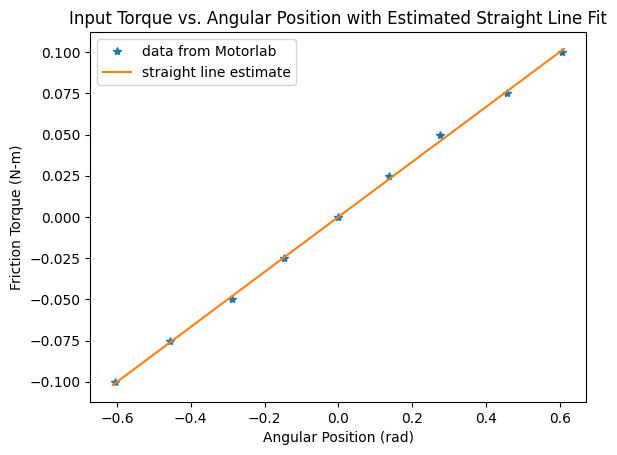

In [14]:
# generate two points for straight line fit
# the spring isn't likely to move more than 30 degrees (went 35 on this motorlab)

# angle estimate
# theta_estimate = [(pi/180) * x for x in [-30, 30]]
theta_estimate = scalar_times_list((pi/180), [-35, 35])

# What is the slope of our motorlab theta vs torque?
# first order polynomial fit (returns slope and intercept)
fit = polyfit(theta, T, 1)

# slope is first element
k_estimate = fit[0]

# Torque estimate using slope found above
# T_estimate = [k_estimate * x for x in theta_estimate]
T_estimate = scalar_times_list(k_estimate, theta_estimate)
 
# plot straight line with data
figure(1)
plot(theta, T, '*', theta_estimate, T_estimate)
ylabel('Friction Torque (N-m)')
xlabel('Angular Position (rad)')
title('Input Torque vs. Angular Position with Estimated Straight Line Fit')
legend(['data from Motorlab','straight line estimate'])
# show()

## Find Damping Ratio using Envelope Fit
Uncomment this section after completing the above section
* Estimate the damping ratio by fitting an envelope to the step response
* Requires step response data has been imported into stepdata
* Uncomment and complete the lines to find zeta

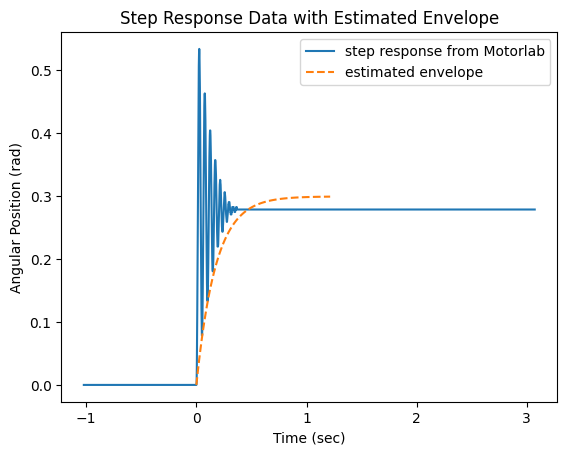

In [15]:
# motor inertia (kg-m^2 or N-m-s^2/rad)
J = 1.1e-5 + 0.19e-5

# spring constant (N-m/rad)
ks = k_estimate
 
# DC gain of transfer function
Kdc = kt/ks

# natural freqency (rad/s)
wn = sqrt(ks / J)

# estimated damping ratio
zeta_estimate = 0.05
 
# Generate a step response from a first order system with a pole
# equal to the real part of the 2nd order poles


# real part of poles 
real_part = zeta_estimate * wn
envelope_TF = tf(Kdc * real_part, [1, real_part])
[envelope_y, envelope_time] = step(envelope_TF)

# Extract data from the experimentally generated step response
stepdata = read_csv("stepdata.csv", header=None)

# extract time column of the data matrix
dataTime = stepdata.iloc[:,0]

# extract third angle column of the data matrix
dataAngle = stepdata.iloc[:,2]

# convert to rad
dataTh = kdr * dataAngle
# How to add markers data tips, scale (xlim ylim), address version control?
# talk about how decision to use matlab comiiler was amde, future work remake the motorlabgui in different location
# cover for zpk, make it look as similar to matlab as possible, FW pipe file into jupyter
figure(2)
plot(dataTime, dataTh, envelope_time, envelope_y, '--')
ylabel('Angular Position (rad)')
xlabel('Time (sec)')
title('Step Response Data with Estimated Envelope')
legend(['step response from Motorlab','estimated envelope'])
show()

## Find coefficients and compare model to experimental data
Uncomment this section after completing the above section
* Find coefficients and compare model to experimental data
* Requires step response has been imported into stepdata
* Uncomment and complete the lines below to generate the step response comparison and to print coeficients

zeta_estimate = 0.05
wn = 113.74589291350878
b = 0.00014673220185842635
wd = 113.60362157213422
Tosc = 0.055307966596733794
J = 1.29e-05
ks = 0.16690185319551917
G = 
                  3876
-----------------------------------------
(s + (5.687-113.6j)) (s + (5.687+113.6j))

G_check = 
                  3876
-----------------------------------------
(s + (5.687-113.6j)) (s + (5.687+113.6j))



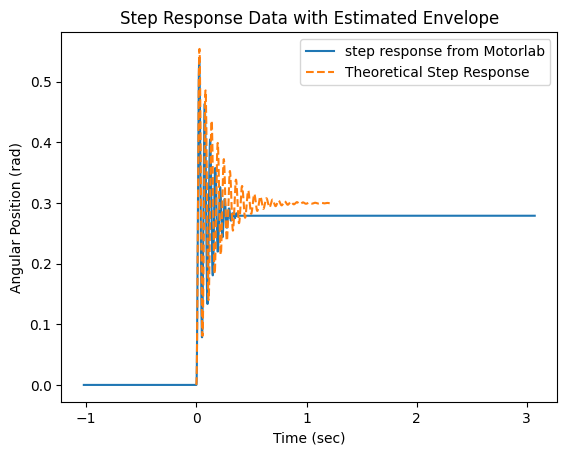

In [16]:
# Print coefficients for different forms of the TF

# damping ratio
print("zeta_estimate = {}".format(zeta_estimate))

# natural frequency (rad/s)
print("wn = {}".format(wn))

# friction coeffienct (N-m-s/rad)
b = 2 * zeta_estimate * wn * J
print("b = {}".format(b))

# damped oscillation frequency (rad/s)
wd = wn * sqrt(1 - zeta_estimate**2)
print("wd = {}".format(wd))

# period of oscillations (sec)
Tosc = 2 * pi / wd
print("Tosc = {}".format(Tosc))

# motor inertia (N-m-s^2/rad)
print("J = {}".format(J))

# spring constant (N-m/rad)
print("ks = {}".format(ks))
 
# Print both forms of the TF
G = tf(kt / J, [1, 2 * zeta_estimate * wn, wn**2], display_format='zpk')
Gcheck = tf(kt, [J, b, ks], display_format='zpk')
print("G = {}".format(G))
print("G_check = {}".format(Gcheck))

# size of step input
I = 1

# get the theoretical step response
[theoryTh, theoryTime] = step(I * G)
 
# DO THE PLOT COMPARING THE ACTUAL STEP RESPONSE TO THE MODEL
figure(3)
plot(dataTime, dataTh, theoryTime, theoryTh, '--')
ylabel('Angular Position (rad)')
xlabel('Time (sec)')
title('Step Response Data with Estimated Envelope')
legend(['step response from Motorlab','Theoretical Step Response'])
show()